# *Строим модель машинного обучения на основе алгоритма Gradient Boosting Regressor*
*В целях предсказывания рейтинга товара в интернет-магазине. В качестве датасета я использовал данные которые собрал на сайте Kaspi.kz о продажах ноутбуков.*


------------------

### *Первым делом импортируем нужные библиотеки*
*После того как мы импортируем библиотеки, мы должны прочитать файл и провести EDA (Разведочный анализ данных, Exploratory Data Analysis) чтобы определить для себя что мы можем получить из этих данных и как с этим дальше работать*

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib

In [2]:
df = pd.read_csv('./Data/product_data_almaty.csv', sep=';', encoding='utf-8')

In [3]:
df.head()

,product,price,rating,recall,instalment,instalment_price,instalment_time
0,Creative Bracket UN-60,2290,9,(221 отзыв),В рассрочку,764 ₸,x3
1,Lenovo IdeaPad 3 15IGL05 81WQ00JBRK серый,129990,9,(36 отзывов),В кредит,8 225 ₸,x24
2,Apple MacBook Air 13 MGN63 серый,448479,10,(388 отзывов),В рассрочку,37 374 ₸,x12
3,Lenovo IdeaPad Gaming 3 16IAH7 82SA00FARK темн...,422899,10,(25 отзывов),В кредит,26 756 ₸,x24
4,Lenovo IdeaPad 1 15ADA7 82R10055RK серый,196410,10,(17 отзывов),В кредит,12 427 ₸,x24


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104 entries, 0 to 1103
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   product           1104 non-null   object
 1   price             1104 non-null   int64 
 2   rating            1104 non-null   int64 
 3   recall            696 non-null    object
 4   instalment        1104 non-null   object
 5   instalment_price  1104 non-null   object
 6   instalment_time   1104 non-null   object
dtypes: int64(2), object(5)
memory usage: 60.5+ KB


In [5]:
df.columns

Index(['product', 'price', 'rating', 'recall', 'instalment',
       'instalment_price', 'instalment_time'],
      dtype='object')

In [6]:
df[['price', 'rating']].describe()

,price,rating
count,1.104000e+03,1104.000000
mean,5.037540e+05,6.636775
std,3.608384e+05,4.509419
min,2.290000e+03,0.000000
25%,2.599900e+05,0.000000
50%,4.200000e+05,10.000000
75%,5.999900e+05,10.000000
max,2.329990e+06,10.000000


In [7]:
df[['product', 'recall', 'instalment', 'instalment_price', 'instalment_time']].describe()

,product,recall,instalment,instalment_price,instalment_time
count,1104,696,1104,1104,1104
unique,857,59,2,607,3
top,Lenovo IdeaPad 3 15ALC6 82KU009MRK серый,(1 отзыв),В кредит,25 306 ₸,x24
freq,4,128,1029,20,1026


In [8]:
df.isnull().sum()

product               0
price                 0
rating                0
recall              408
instalment            0
instalment_price      0
instalment_time       0
dtype: int64

### *Пропуски в датасете*
*Как мы могли заметить товары в которых не было отзыва не всегда имеет низкий рейтинг, во время построения модели эти данные могут снизить точность нашей модели, заменять их на среднее значение не имеет смысла. Лучше уберём их.*

In [9]:
df[df.recall.isnull()]

,product,price,rating,recall,instalment,instalment_price,instalment_time
85,HP 15s-fq5033ci 725V9EA серебристый,259888,10,NaN,В кредит,16 443 ₸,x24
93,ASUS TUF Gaming A15 FA507RM-HN003 90NR09C1-M00...,459990,0,NaN,В кредит,29 102 ₸,x24
119,Apple MacBook Air 15 2023 MQKR3 серебристый,719000,0,NaN,В рассрочку,59 917 ₸,x12
125,Acer Extensa 15 EX215-31-C1JG NX.EFTER.00F черный,147700,10,NaN,В кредит,9 345 ₸,x24
137,Acer Extensa 15 EX215-31-C1JG NX.EFTER.00F черный,147700,10,NaN,В кредит,9 345 ₸,x24
...,...,...,...,...,...,...,...
1094,Acer Extensa 15 EX215-54-36D0 NX.EGJER.00H черный,280990,10,NaN,В кредит,17 778 ₸,x24
1095,HP Zbook Fury 17 G8 62T12EA серый,1432899,0,NaN,В кредит,90 655 ₸,x24
1096,HP ProBook 450 G8 UMA 2W1G9EA серебристый,547000,0,NaN,В кредит,34 607 ₸,x24
1100,ASUS X509MA-BR113T 90NB0Q32-M03680 серый,229990,10,NaN,В кредит,14 551 ₸,x24


In [10]:
df = df.dropna()

#### *Извлечение числовые и качественные значения.*

*Для построения модели машинного обучения нам нужно получить все числовые и качественные (категориальные) значения из данного датасета. Как например, здесь мы получаем количество отзывов, ставим flag для колонки* **'instalment'** *, а так же получаем значения по сумме и сроку кредитования*

In [11]:
# Извлечение числовых и качественных значений из строковых столбцов
df['new_recall'] = df['recall'].str.extract('(\d+)').fillna(0).astype(int)
df['new_instalment'] = df['instalment'].apply(lambda x: 1 if x == 'В кредит' else 0)
df['new_instalment_price'] = df['instalment_price'].str.replace('₸', '').str.replace(' ', '').astype(int)
df['new_instalment_time'] = df['instalment_time'].str.extract('(\d+)').astype(int)

In [12]:
df.head()

,product,price,rating,recall,instalment,instalment_price,instalment_time,new_recall,new_instalment,new_instalment_price,new_instalment_time
0,Creative Bracket UN-60,2290,9,(221 отзыв),В рассрочку,764 ₸,x3,221,0,764,3
1,Lenovo IdeaPad 3 15IGL05 81WQ00JBRK серый,129990,9,(36 отзывов),В кредит,8 225 ₸,x24,36,1,8225,24
2,Apple MacBook Air 13 MGN63 серый,448479,10,(388 отзывов),В рассрочку,37 374 ₸,x12,388,0,37374,12
3,Lenovo IdeaPad Gaming 3 16IAH7 82SA00FARK темн...,422899,10,(25 отзывов),В кредит,26 756 ₸,x24,25,1,26756,24
4,Lenovo IdeaPad 1 15ADA7 82R10055RK серый,196410,10,(17 отзывов),В кредит,12 427 ₸,x24,17,1,12427,24


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 696 entries, 0 to 1103
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   product               696 non-null    object
 1   price                 696 non-null    int64 
 2   rating                696 non-null    int64 
 3   recall                696 non-null    object
 4   instalment            696 non-null    object
 5   instalment_price      696 non-null    object
 6   instalment_time       696 non-null    object
 7   new_recall            696 non-null    int32 
 8   new_instalment        696 non-null    int64 
 9   new_instalment_price  696 non-null    int32 
 10  new_instalment_time   696 non-null    int32 
dtypes: int32(3), int64(3), object(5)
memory usage: 57.1+ KB


In [14]:
df.columns

Index(['product', 'price', 'rating', 'recall', 'instalment',
       'instalment_price', 'instalment_time', 'new_recall', 'new_instalment',
       'new_instalment_price', 'new_instalment_time'],
      dtype='object')

In [15]:
df[['price', 'rating', 'new_recall', 'new_instalment',
       'new_instalment_price', 'new_instalment_time']].describe()

,price,rating,new_recall,new_instalment,new_instalment_price,new_instalment_time
count,6.960000e+02,696.000000,696.000000,696.000000,696.000000,696.000000
mean,4.520891e+05,9.610632,12.958333,0.909483,30096.439655,22.784483
std,3.072211e+05,0.835784,31.143247,0.287128,22740.346286,3.841776
min,2.290000e+03,2.000000,1.000000,0.000000,764.000000,3.000000
25%,2.499000e+05,9.000000,2.000000,1.000000,15811.000000,24.000000
50%,3.999375e+05,10.000000,5.000000,1.000000,25303.500000,24.000000
75%,5.499900e+05,10.000000,13.000000,1.000000,35696.000000,24.000000
max,2.299990e+06,10.000000,388.000000,1.000000,178479.000000,24.000000


###  *Корреляция числовых значений*
*На данном этапе нам нужно выявить корреляцию числовых значений, для этого лучше всего подойдёт матрица корреляции. (На самом деле уже на данном этапе понятно что рейтинг товара напрямую зависит от количество хороших отзывов, но для наглядности построим и проанализируем матрицу зависимостей).*

In [16]:
df_selected = df[['price', 'rating', 'new_recall', 'new_instalment', 'new_instalment_price', 'new_instalment_time']]
corr = df_selected.corr()
corr.style.background_gradient(cmap='coolwarm')

,price,rating,new_recall,new_instalment,new_instalment_price,new_instalment_time
price,1.000000,0.123172,-0.096181,-0.368091,0.979668,-0.283885
rating,0.123172,1.000000,0.021653,-0.087120,0.123360,-0.054852
new_recall,-0.096181,0.021653,1.000000,-0.325455,-0.058768,-0.365712
new_instalment,-0.368091,-0.087120,-0.325455,1.000000,-0.521075,0.956670
new_instalment_price,0.979668,0.123360,-0.058768,-0.521075,1.000000,-0.428384
new_instalment_time,-0.283885,-0.054852,-0.365712,0.956670,-0.428384,1.000000


### *Улучшаем визуальную составляющую*
*Сделаем график более красивым и читабельным. Здесь мы можем видеть что сумма кредита/рассрочки напрямую зависит от общей цены (что логично), а период кредитования/рассрочки напрямую зависит от вида разновидности кредитования (что тоже логично), мы можем предположить что меньший срок подразумевает под собой покупку в рассрочку.*

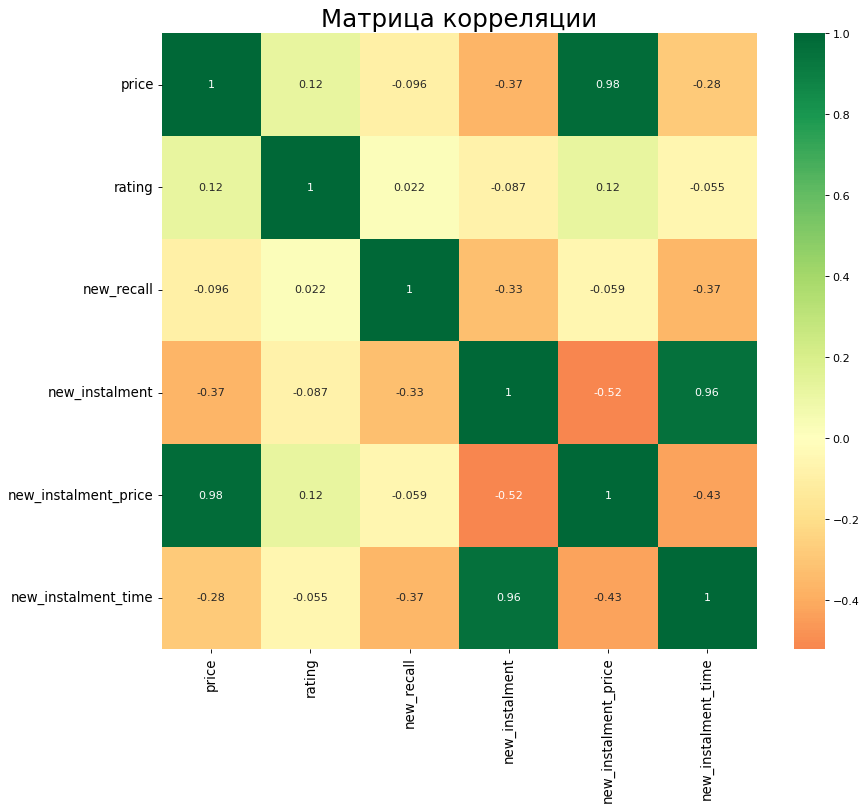

In [17]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(df_selected.corr(), xticklabels=df_selected.corr().columns, \
            yticklabels=df_selected.corr().columns, cmap='RdYlGn', center=0, annot=True)

plt.title('Матрица корреляции', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### *График рассеяния для анализа взаимосвязи между отзывами и рейтингом*

*Для того чтобы проанализировать связь между количеством отзывов и рейтингом, построим график рассеяния. График рассеяния поможет нам определить, существует ли какая-либо видимая зависимость между этими двумя переменными.*

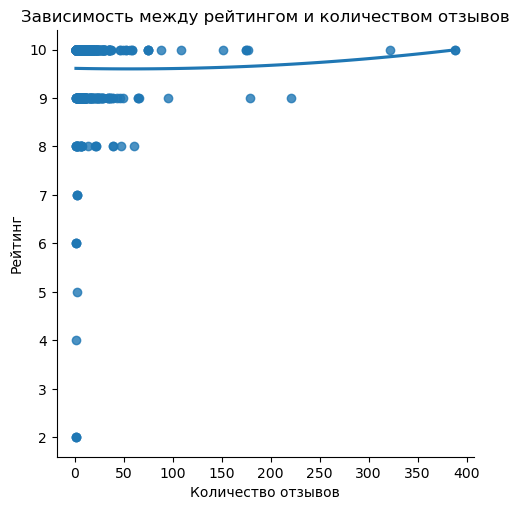

In [18]:
sns.lmplot(x ="new_recall", y ="rating", data = df_selected[['rating', 'new_recall']], 
           order = 2, ci = None)

plt.title('Зависимость между рейтингом и количеством отзывов')
plt.xlabel('Количество отзывов')
plt.ylabel('Рейтинг')
plt.show()

### Приступаем к построению и обучению модели.
#### Для построения модели мы выполним следующие шаги:
- Разделяем данные на признаки и целевую переменную которую мы ходим предугадывать.
- Создаём и обучаем модель исользую алгоритм ***Gradient Boosting Regressor***.
- Попробуем предсказать рейтинг на тестовом наборе данных.
- Оценим качество модели с помощью специальных метрик:
    - Среднеквадратичная ошибка (MSE).
    - Корень из среднеквадратичной ошибки (RMSE).
    - Средняя абсолютная ошибка (MAE).
- Сохраняем модель. Я сохранил их двумя способами:
    - Первый способ это сохранение с помощью библиотеки ***pickle***, он реализован на языке **'C'** и это модуль, встроенный в Python, который более хорошо себя показывает на небольших наборов данных.
    - Второй способ это сохранение с использованием библиотеки ***joblib***. Это набор инструментов для упрощения конвейерной обработки в Python. Библиотека оптимизирована, чтобы быть быстрой и надежной, в частности, для больших данных, и имеет специальные оптимизации для массивов NumPy.

In [19]:
# Разделение данных на признаки и целевую переменную
X = df_selected[['price', 'new_recall', 'new_instalment', 'new_instalment_price', 'new_instalment_time']]
y = df_selected['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# Создание и обучение модели Gradient Boosting
model = GradientBoostingRegressor(random_state=30)
model.fit(X_train, y_train)

# Предсказание рейтинга на тестовом наборе данных
y_pred = model.predict(X_test)

# Оценка модели
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) #default=True
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False)
 
# Сохранение модели с помощью библиотеки pickle
filename = 'GradientBoostingRegressor.sav'
pickle.dump(model, open(filename, 'wb'))

# Сохранение модели с помощью библиотеки joblib
model_filename = 'GradientBoostingRegressor.pkl'
joblib.dump(model, model_filename)

print(f"Средняя абсолютная ошибка: {mae}")
print('--------------------------------------')
print(f"Среднеквадратичное отклонение: {rmse}")
print('--------------------------------------')
print(f"Среднеквадратичная ошибка: {mse}")
print('--------------------------------------')
print("Предсказанный рейтинг:", y_pred)

Средняя абсолютная ошибка: 0.5114952334257383
--------------------------------------
Среднеквадратичное отклонение: 0.9128876742179698
--------------------------------------
Среднеквадратичная ошибка: 0.8333639057390942
--------------------------------------
Предсказанный рейтинг: [ 9.66826939  9.75106952  9.80015396  9.99506299  9.55947856  9.6711087
  9.50355357  9.88506604  9.79749441  9.55775893  9.7535427   8.89749954
  8.94234041  9.92559275  9.72409573  9.59042634  9.63621495  9.54461966
  9.7463665   9.37163078  9.74975947  9.72800046 10.00695844  9.76060072
  9.55775893  9.79506754  9.96741984  9.54027397  9.78515237  9.63621495
  9.61869003  9.62345319  9.98468714  9.80748789  9.68155593  9.7734055
  9.81983631  9.64172789  9.80983935  9.04912159  9.7995704   9.52076703
  9.63621495  9.41171418  9.42196476  9.68083397  9.96741984  8.88159384
  9.72591867  9.84264169  8.9065723   9.54027397  9.75808007  9.72990907
  9.94457562  9.79517942  9.85739812  9.71144164  9.52076703  9

#### Модель с использованием библиотеки ***XGBRegressor***.
Далее я повторно реализовал модель только с использованием библиотеки *** XGBRegressor *** в целях сравнить полученный результат и расширить кругозор знаний. Но как оказалось расширять ничего не надо и весь процесс написания кода для новой модели был сведён к минимуму.

In [20]:
# Разделение данных на признаки и целевую переменную
X = df_selected[['price', 'new_recall', 'new_instalment', 'new_instalment_price', 'new_instalment_time']]
y = df_selected['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# Создание и обучение модели XGBRegressor
model = XGBRegressor(random_state=30)
model.fit(X_train, y_train)

# Предсказание рейтинга на тестовом наборе данных
y_pred = model.predict(X_test)

# Оценка модели
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) #default=True
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False)

# Сохранение модели с помощью библиотеки pickle
filename = 'XGBRegressor.sav'
pickle.dump(model, open(filename, 'wb'))

# Сохранение модели с помощью библиотеки joblib
model_filename = 'XGBRegressor.pkl'
joblib.dump(model, model_filename)

print(f"Средняя абсолютная ошибка: {mae}")
print('--------------------------------------')
print(f"Среднеквадратичное отклонение: {rmse}")
print('--------------------------------------')
print(f"Среднеквадратичная ошибка: {mse}")
print('--------------------------------------')
print("Предсказанный рейтинг:", y_pred)

Средняя абсолютная ошибка: 0.45595837320600235
--------------------------------------
Среднеквадратичное отклонение: 0.9764989092299197
--------------------------------------
Среднеквадратичная ошибка: 0.9535501197272229
--------------------------------------
Предсказанный рейтинг: [ 9.805102   9.980118   9.903003  10.00693    9.267141   9.111878
  9.364971   9.9574995  9.418504   9.082377   9.585186   8.603327
  9.005368   9.979112   9.817525   9.5182085  9.060317   9.03237
 10.170304   9.127096   9.337631   9.8172035 10.008328   9.943733
  9.073482   9.025708  10.01237    9.342398  10.005136   9.633576
  9.853672  10.061192   9.99421    9.992479   9.819726  10.01061
 10.027015   9.650814  10.205996   9.942065   9.997859   9.2765045
  9.982889   8.566762   9.43102    9.906564  10.01237    8.54982
  9.949336   9.905112   8.815327   9.342398   9.96503    9.996483
  9.96918    9.944165   9.989634  10.012087   9.204276   9.078441
  8.921095   9.850579   9.320864   9.962448  10.001742  10.

### Далее я беру рандомную строку из датасета и передаю значения X предсказанной нами модели чтобы наглядно сравнить полученный результат с фактическим.
Уже на этом этапе можно бросить учить **'ML'**, так как моя модель не угадала. Но тем не менее это ли не мотивация чтобы вырасти и попытаться снова. Мне было очень интересно изучать и пробовать что-то новое, чем я и занимаюсь всю жизнь. Это лишь небольшой пример того, как можно выстроить модель. В дальнейшех своих проектах я буду больше углубляться и строить модели с высоким **predict** значением. Спасибо за уделенное время и внимание.

In [21]:
df.loc[502]

product                 GIGABYTE G5 MF MF-E2KZ333SD черный
price                                               449848
rating                                                   5
recall                                          (2 отзыва)
instalment                                        В кредит
instalment_price                                  28 461 ₸
instalment_time                                        x24
new_recall                                               2
new_instalment                                           1
new_instalment_price                                 28461
new_instalment_time                                     24
Name: 502, dtype: object

In [23]:
# Загрузка модели из файла
loaded_model_sklearn = joblib.load('GradientBoostingRegressor.pkl')

# Создание данных для предсказания (замените значения на реальные данные)
new_data = [[44989, 2, 1, 28461, 24]]

# Предсказание с использованием загруженной модели
predicted_rating = loaded_model_sklearn.predict(new_data)

# Оценка модели
mae_sklearn = mean_absolute_error([5], predicted_rating)
mse_sklearn = mean_squared_error([5], predicted_rating)
rmse_sklearn = mean_squared_error([5], predicted_rating, squared=False)
print(f"Средняя абсолютная ошибка: {mae_sklearn}")
print('--------------------------------------')
print(f"Среднеквадратичное отклонение: {mse_sklearn}")
print('--------------------------------------')
print(f"Среднеквадратичная ошибка: {rmse_sklearn}")
print('--------------------------------------')
print("Предсказанный рейтинг:", predicted_rating)

Средняя абсолютная ошибка: 2.1701790962938654
--------------------------------------
Среднеквадратичное отклонение: 4.709677309990858
--------------------------------------
Среднеквадратичная ошибка: 2.1701790962938654
--------------------------------------
Предсказанный рейтинг: [7.1701791]


C:\Users\almat\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
